# 第九章　自然エネルギー利用設備 / Chapter 9 Natural energy utilization equipment

## 第三節　空気集熱式太陽熱利用設備 / Section 3 Air based solar system

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# 試算例

In [2]:
def get_default_air_based_solar_system():
    base = {'region': 6, 'sol_region': 3, 'A_A': 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51,
            "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8, 'L_HWH': None,
            "H_MR": {'type': 'ルームエアコンディショナー', 'e_class': 'は', 'dualcompressor': False},
            "H_OR": {'type': 'ルームエアコンディショナー', 'e_class': 'は', 'dualcompressor': False}}

    HW = {'hw_type' : 'ガス従来型給湯機', 'e_rtd' : 0.704, 'e_dash_rtd' : None, 'hybrid_category' : None,
          'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
          'kitchen_watersaving_A' : False, 'kitchen_watersaving_C' : False,  'shower_watersaving_A' : False,
          'shower_watersaving_B' : False, 'washbowl_watersaving_C' : False, 'bath_insulation' : False}

    SHC = {'type': '空気集熱式',
           'P_alpha': 0, 'fan_sso': False, 'fan_type': 'AC', 'V_fan_P0': 30, 'hotwater_use': False, 'pump_sso': False, 'W_tnk_ass': None,
           'supply_target': '居室', 'r_A_ufvnt_ass': None, 'ufv_insulation': None, 'A_col': (3,), 'P_beta': (30,), 'd0': (0.1,), 
           'd1': (2.0,), 'm_fan_test': (0.0107,)}

    return base, HW, SHC

In [3]:
def calc_results(base, HW, SHC):

    from pyhees.section2_1_c import get_n_p
    from pyhees.section2_1_b import get_f_prim
    from pyhees.section3_1 import get_Q
    from pyhees.section3_1_heatingday import get_heating_flag_d
    from pyhees.section3_2 import calc_r_env, get_Q_dash, get_mu_H, get_mu_C
    from pyhees.section4_1 import calc_heating_load, get_alpha_UT_H_MR, get_alpha_UT_H_OR, calc_heating_mode, calc_A_HCZ_i, get_E_E_aux_ass_d_t
    from pyhees.section4_3 import calc_E_E_H_d_t, get_E_G_H_d_t, get_E_K_H_d_t, get_E_M_H_d_t, calc_Q_UT_H_d_t
    from pyhees.section4_3_a import get_q_rtd_C, get_q_rtd_H, get_e_rtd_C, get_e_rtd_H
    from pyhees.section7_1 import calc_E_E_W_d_t, calc_E_G_W_d_t, calc_E_K_W_d_t


    L_HWH = base['L_HWH']
    region = base['region']
    sol_region = base['sol_region']
    A_A = base['A_A']
    n_p = get_n_p(A_A)

    # 度をラジアンに変換
    if SHC is not None:
        if SHC['type'] == '空気集熱式':
            SHC['P_alpha'] = np.radians(SHC['P_alpha'])

            P_beta_radians = []
            for P_beta_degree in SHC['P_beta']:
                P_beta_radians.append(np.radians(P_beta_degree))
            SHC['P_beta'] = tuple(P_beta_radians)

    A_A = base["A_A"]
    A_MR = base["A_MR"]
    A_OR = base["A_OR"]
    A_env = base["A_env"]
    U_A = base["U_A"]
    eta_A_H = base["eta_A_H"]
    eta_A_C = base["eta_A_C"]
    NV_MR = 0
    NV_OR = 0
    r_A_ufvnt = None
    underfloor_insulation = None
    TS = None
    HEX = None

    mode_C = "居室のみを冷房する方式"
    mode_H = '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合'
    H_MR = base["H_MR"]
    H_OR = base["H_OR"]

    # 床面積の合計に対する外皮の部位の面積の合計の比
    r_env = calc_r_env(method='当該住戸の外皮の部位の面積等を用いて外皮性能を評価する方法',
                        A_env=A_env, A_A=A_A)

    # 熱損失係数
    Q_dash = get_Q_dash(U_A, r_env)
    Q = get_Q(Q_dash)

    # 日射取得係数
    mu_H = get_mu_H(eta_A_H, r_env)
    mu_C = get_mu_C(eta_A_C, r_env)

    # 暖房方式及び運転方法の区分
    mode_MR, mode_OR = calc_heating_mode(
        region=region, H_MR=H_MR, H_OR=H_OR)

    # 暖房負荷
    L_T_H_d_t_i, L_dash_H_R_d_t_i = \
        calc_heating_load(region, sol_region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX,
                            underfloor_insulation, mode_H, mode_C, spec_MR=H_MR, spec_OR=H_OR, mode_MR=mode_MR, mode_OR=mode_OR, SHC=SHC)
    
    # 暖房日の取得
    if SHC != None and SHC['type'] == '空気集熱式':
        heating_flag_d = get_heating_flag_d(L_dash_H_R_d_t_i)
    else:
        heating_flag_d = None
   

    # 暖房（ルームエアコンのみに対応）
    E_H_d_t = np.zeros(365*24)
    for i in range(1,6):

        # 暖冷房仕様の取得
        A_HCZ = calc_A_HCZ_i(i, base['A_A'], base['A_MR'], base['A_OR'])
        q_rtd_C = get_q_rtd_C(A_HCZ)
        q_rtd_H = get_q_rtd_H(q_rtd_C)

        if i == 1 and H_MR is not None:
            e_rtd_C = get_e_rtd_C(H_MR['e_class'], q_rtd_C)
            dualcompressor_H = H_MR['dualcompressor']
        elif 2 <= i <= 5 and H_OR is not None:
            e_rtd_C = get_e_rtd_C(H_OR['e_class'], q_rtd_C)
            dualcompressor_H = H_OR['dualcompressor']
        else:
            e_rtd_C = None
        
        e_rtd_H = get_e_rtd_H(e_rtd_C)


        # 暖房用の電気消費量
        E_E_H_d_t = calc_E_E_H_d_t(region=base['region'], q_rtd_C=q_rtd_C, q_rtd_H=q_rtd_H, e_rtd_H=e_rtd_H, dualcompressor=dualcompressor_H, L_H_d_t=L_T_H_d_t_i[i-1])
    
        # 暖房用のガス消費量
        E_G_H_d_t = get_E_G_H_d_t()

        # 暖房用の灯油
        E_K_H_d_t = get_E_K_H_d_t()

        # 暖房用のその他の燃料
        E_M_H_d_t = get_E_M_H_d_t()

        # 未処理暖房負荷の設計一次エネルギー消費量相当値
        Q_UT_H_d_t = calc_Q_UT_H_d_t(base['region'], q_rtd_C, q_rtd_H, e_rtd_H, L_H_d_t=L_T_H_d_t_i[i-1])
        alpha_UT_H = get_alpha_UT_H_MR(base['region'], mode_MR) if i == 1 else get_alpha_UT_H_OR(base['region'], mode_OR)
        E_UT_H_d_t = Q_UT_H_d_t * alpha_UT_H

        # 電気の一次エネルギー換算係数
        f_prim = get_f_prim()

        E_H_d_t_i = E_E_H_d_t * f_prim / 1000 + E_G_H_d_t + E_K_H_d_t + E_M_H_d_t + E_UT_H_d_t
        E_H_d_t += E_H_d_t_i

    # 空気集熱式太陽熱利用設備の補機の消費電力量のうちの暖房設備への付加分
    E_E_aux_ass_d_t = get_E_E_aux_ass_d_t(SHC, heating_flag_d, region, sol_region)
    E_H_d_t += E_E_aux_ass_d_t * f_prim / 1000

    # 給湯
    E_E_W_d_t = calc_E_E_W_d_t(n_p, L_HWH, heating_flag_d, region, sol_region, HW, SHC)
    E_G_W_d_t = calc_E_G_W_d_t(n_p, L_HWH, heating_flag_d, A_A, region, sol_region, HW, SHC)
    E_K_W_d_t = calc_E_K_W_d_t(n_p, L_HWH, heating_flag_d, A_A, region, sol_region, HW, SHC)

    f_prim = get_f_prim()
    E_W_d_t = E_E_W_d_t * f_prim / 1000 + E_G_W_d_t + E_K_W_d_t

    print(f'E_H_d_t = {np.sum(E_H_d_t)}MJ/a')
    print(f'E_W_d_t = {np.sum(E_W_d_t)}MJ/a')

    return E_H_d_t, E_W_d_t

In [4]:
def get_each_graph(_results):

    results_sum_day = np.sum(_results.reshape(365,24), axis = 1)
    results_mean_hour = np.mean(_results.reshape(365,24), axis = 0)

    fig = plt.figure(figsize = (20,12))
    grh1 = fig.add_subplot(311)
    grh1.set_ylabel('MJ/h')
    grh1.set_xlabel('hour')
    grh1.plot(_results)

    grh_day = fig.add_subplot(312)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(results_sum_day)

    grh_hour = fig.add_subplot(313)
    grh_hour.plot(results_mean_hour)
    grh_hour.set_ylabel('MJ/h')
    grh_hour.set_xlabel('hour')

    plt.show()


### 計算条件1

- 初期条件での計算

In [5]:
base, HW, SHC = get_default_air_based_solar_system()
E_H_d_t_1, E_W_d_t_1 = calc_results(base, HW, SHC)

空気集熱式太陽熱利用設備の補機の消費電力量のうちの暖房設備への付加分 E_E_aux_ass = 3.9120000000000004 [kWh/年]
L_ba = 1339.0568333333335
W_k = 35806.0
W_s = 58690.0
W_w = 9454.0
W_b1 = 0.0
W_b2 = 60300.0
W_ba1 = 0.0
W_dash_k = 35806.0
W_dash_s = 58690.0
W_dash_w = 9454.0
W_dash_b1 = 0.0
W_dash_b2 = 60300.0
W_dash_ba1 = 0.0
L_dash_k = 3622.896051970286
L_dash_s = 5940.34804910638
L_dash_w = 957.2672611235673
L_dash_b1 = 0.0
L_dash_b2 = 6097.813467345601
L_dash_ba1 = 0.0
L_dash_ba2 = 1673.8210416666666
L_dashdash_k = 3622.896051970286
L_dashdash_s = 5940.34804910638
L_dashdash_w = 957.2672611235673
L_dashdash_b1 = 0.0
L_dashdash_b2 = 6097.813467345601
L_dashdash_ba1 = 0.0
L_dashdash_ba2 = 1673.8210416666666
E_E_hs_aux1 = 37.22433263888889
E_E_hs_aux2 = 6.513888888888888
E_E_hs_aux3 = 13.686551818865741
E_H_d_t = 13969.494179380305MJ/a
E_W_d_t = 27637.31547105188MJ/a


暖房


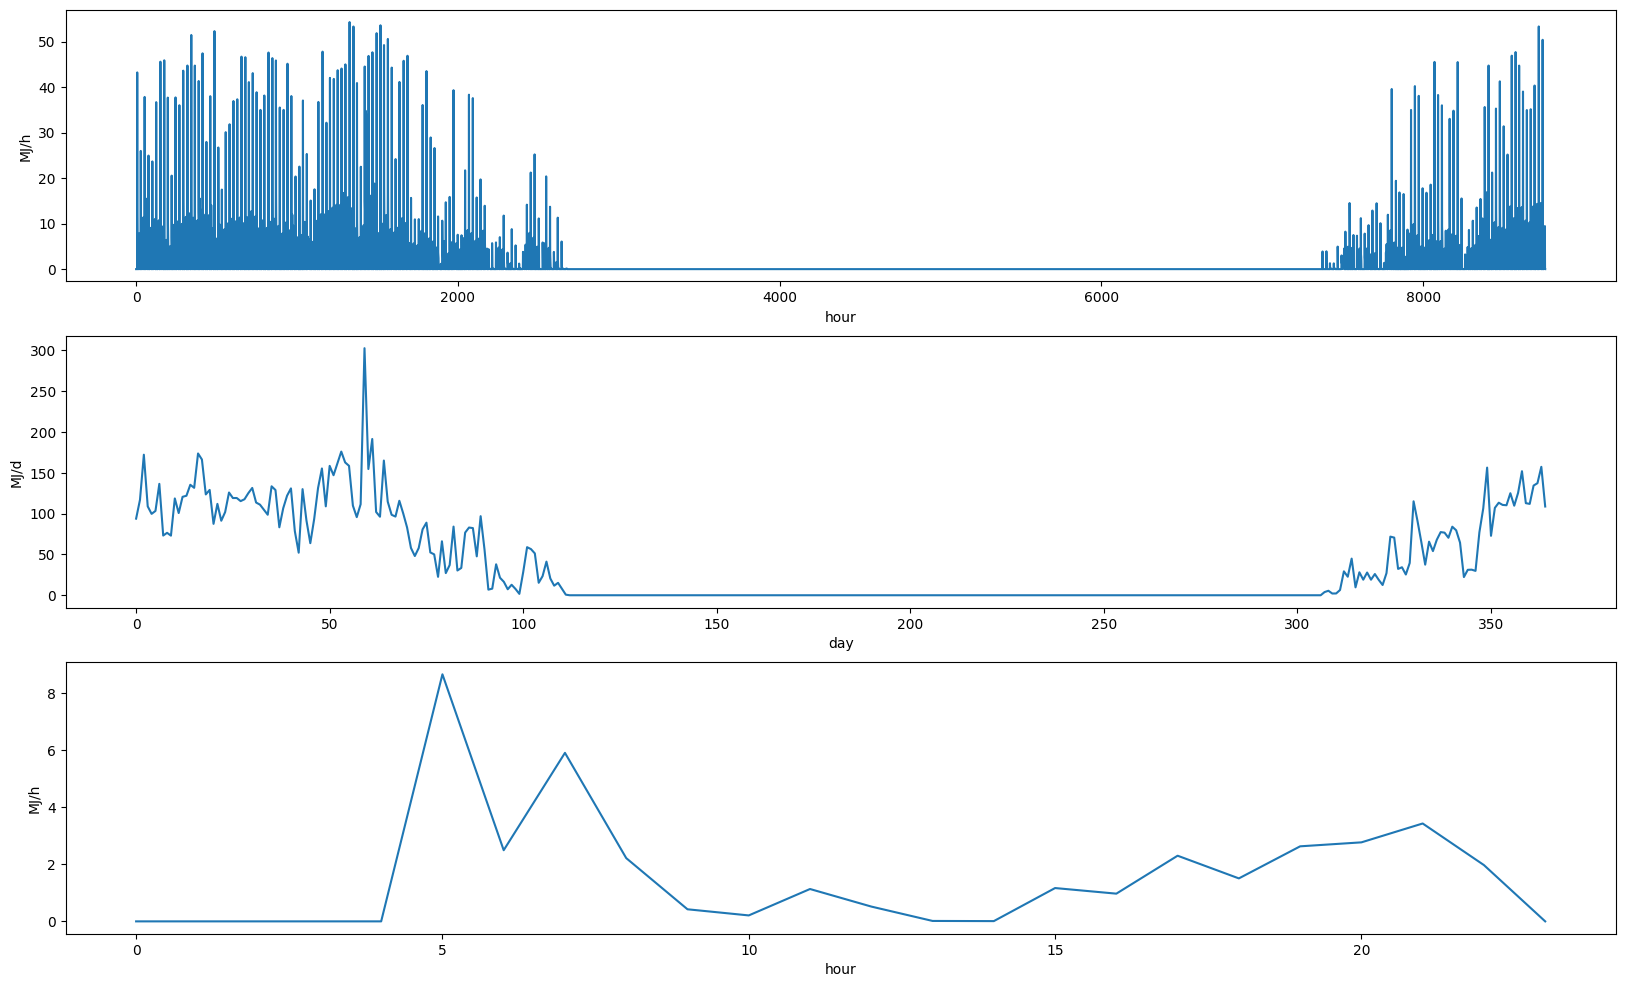

給湯


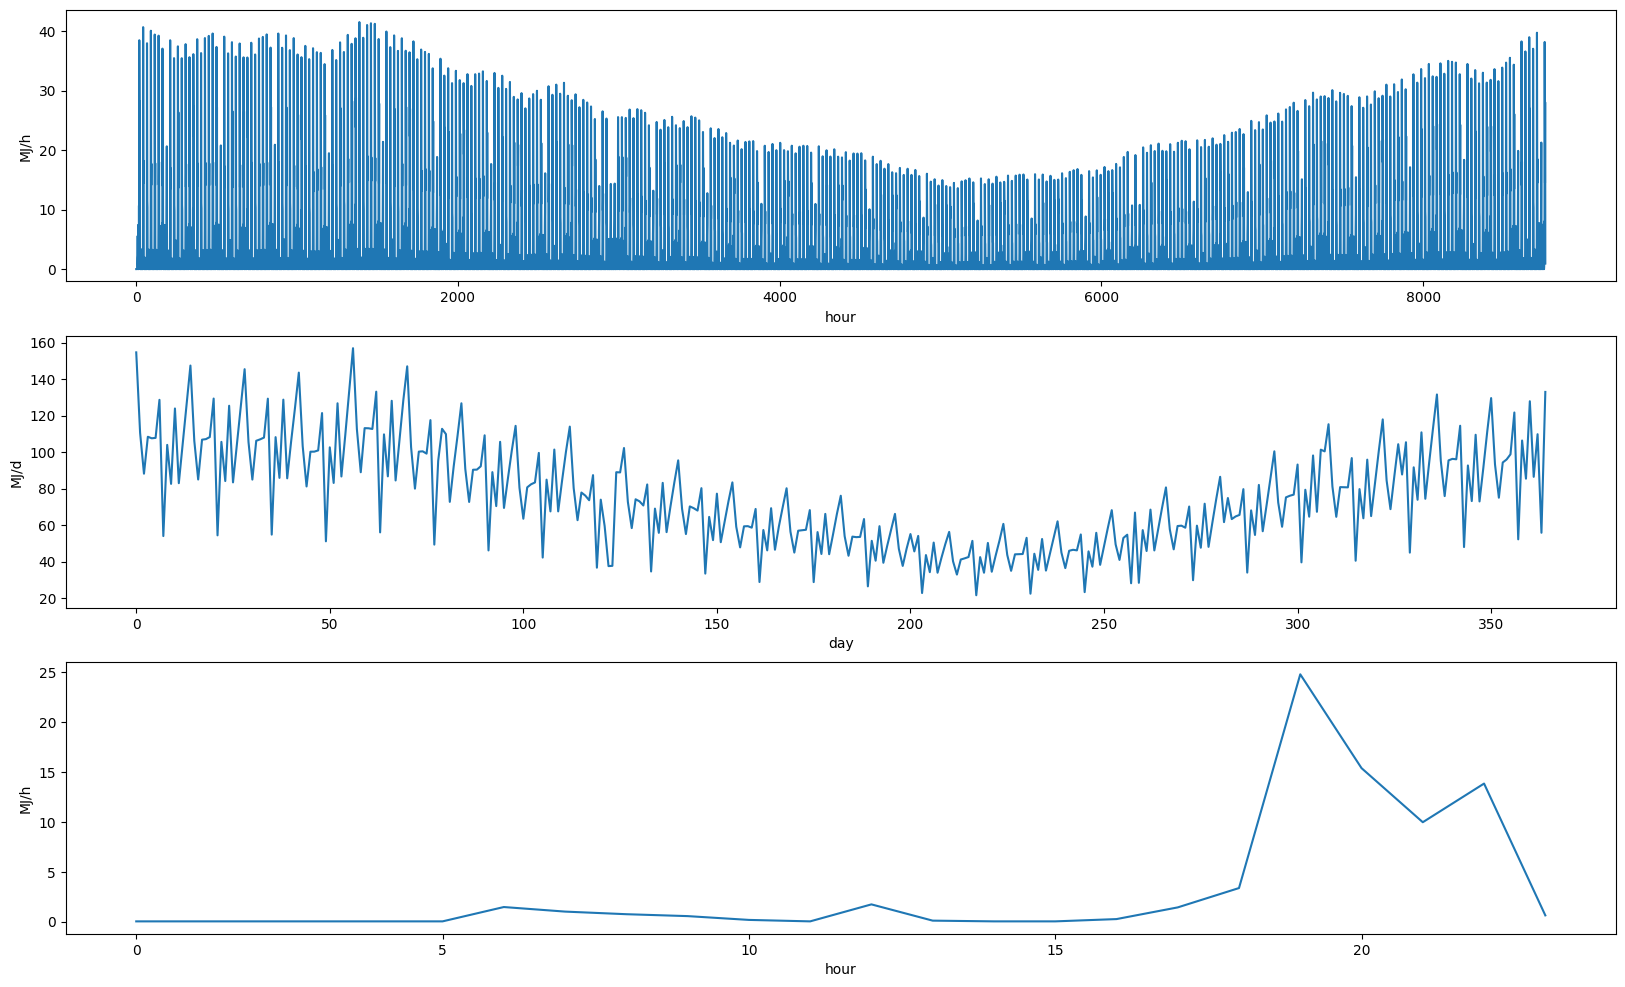

In [6]:
print('暖房')
get_each_graph(E_H_d_t_1)
print('給湯')
get_each_graph(E_W_d_t_1)

### 計算条件2

- 方位角、空気搬送ファンのPV、空気搬送ファン種別、機外静圧0時の空気搬送ファン風量を変更

In [7]:
base, HW, SHC = get_default_air_based_solar_system()
SHC['P_alpha'] = 180
SHC['fan_sso'] = True
SHC['fan_type'] = 'DC'
SHC['V_fan_P0'] = 300
E_H_d_t_2, E_W_d_t_2 = calc_results(base, HW, SHC)

空気集熱式太陽熱利用設備の補機の消費電力量のうちの暖房設備への付加分 E_E_aux_ass = 0.0 [kWh/年]
L_ba = 1339.0568333333335
W_k = 35806.0
W_s = 58690.0
W_w = 9454.0
W_b1 = 0.0
W_b2 = 60300.0
W_ba1 = 0.0
W_dash_k = 35806.0
W_dash_s = 58690.0
W_dash_w = 9454.0
W_dash_b1 = 0.0
W_dash_b2 = 60300.0
W_dash_ba1 = 0.0
L_dash_k = 3622.896051970286
L_dash_s = 5940.34804910638
L_dash_w = 957.2672611235673
L_dash_b1 = 0.0
L_dash_b2 = 6097.813467345601
L_dash_ba1 = 0.0
L_dash_ba2 = 1673.8210416666666
L_dashdash_k = 3622.896051970286
L_dashdash_s = 5940.34804910638
L_dashdash_w = 957.2672611235673
L_dashdash_b1 = 0.0
L_dashdash_b2 = 6097.813467345601
L_dashdash_ba1 = 0.0
L_dashdash_ba2 = 1673.8210416666666
E_E_hs_aux1 = 37.22433263888889
E_E_hs_aux2 = 6.513888888888888
E_E_hs_aux3 = 13.686551818865741
E_H_d_t = 13935.00484492587MJ/a
E_W_d_t = 27637.31547105188MJ/a


暖房


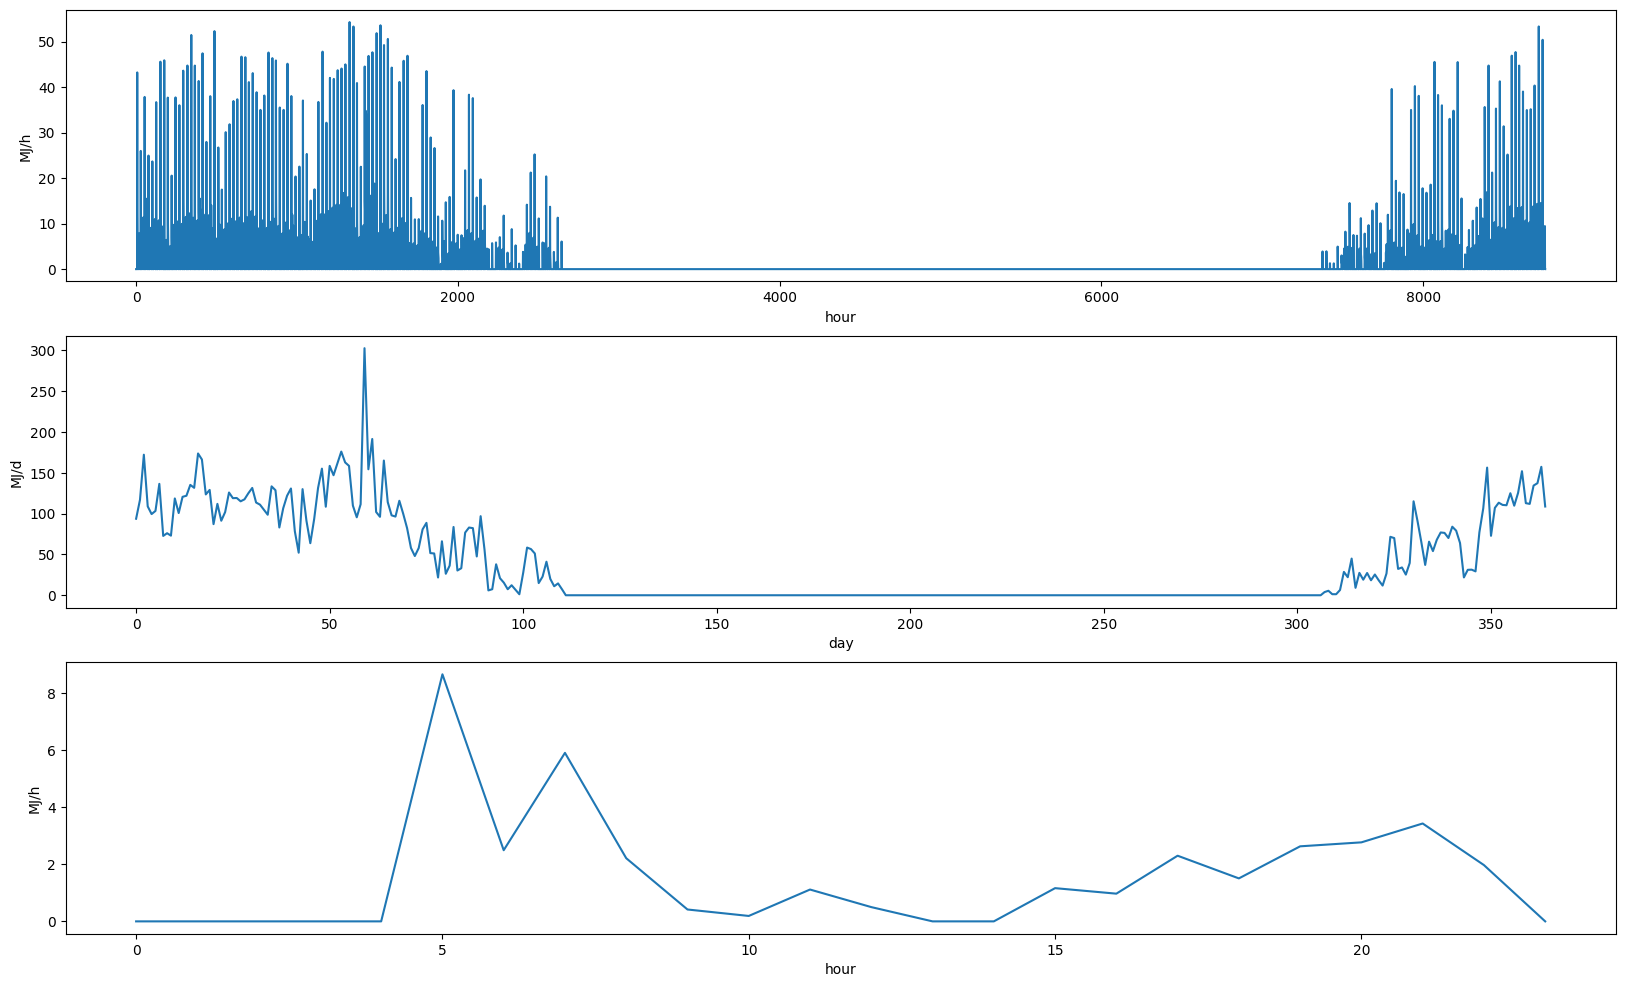

給湯


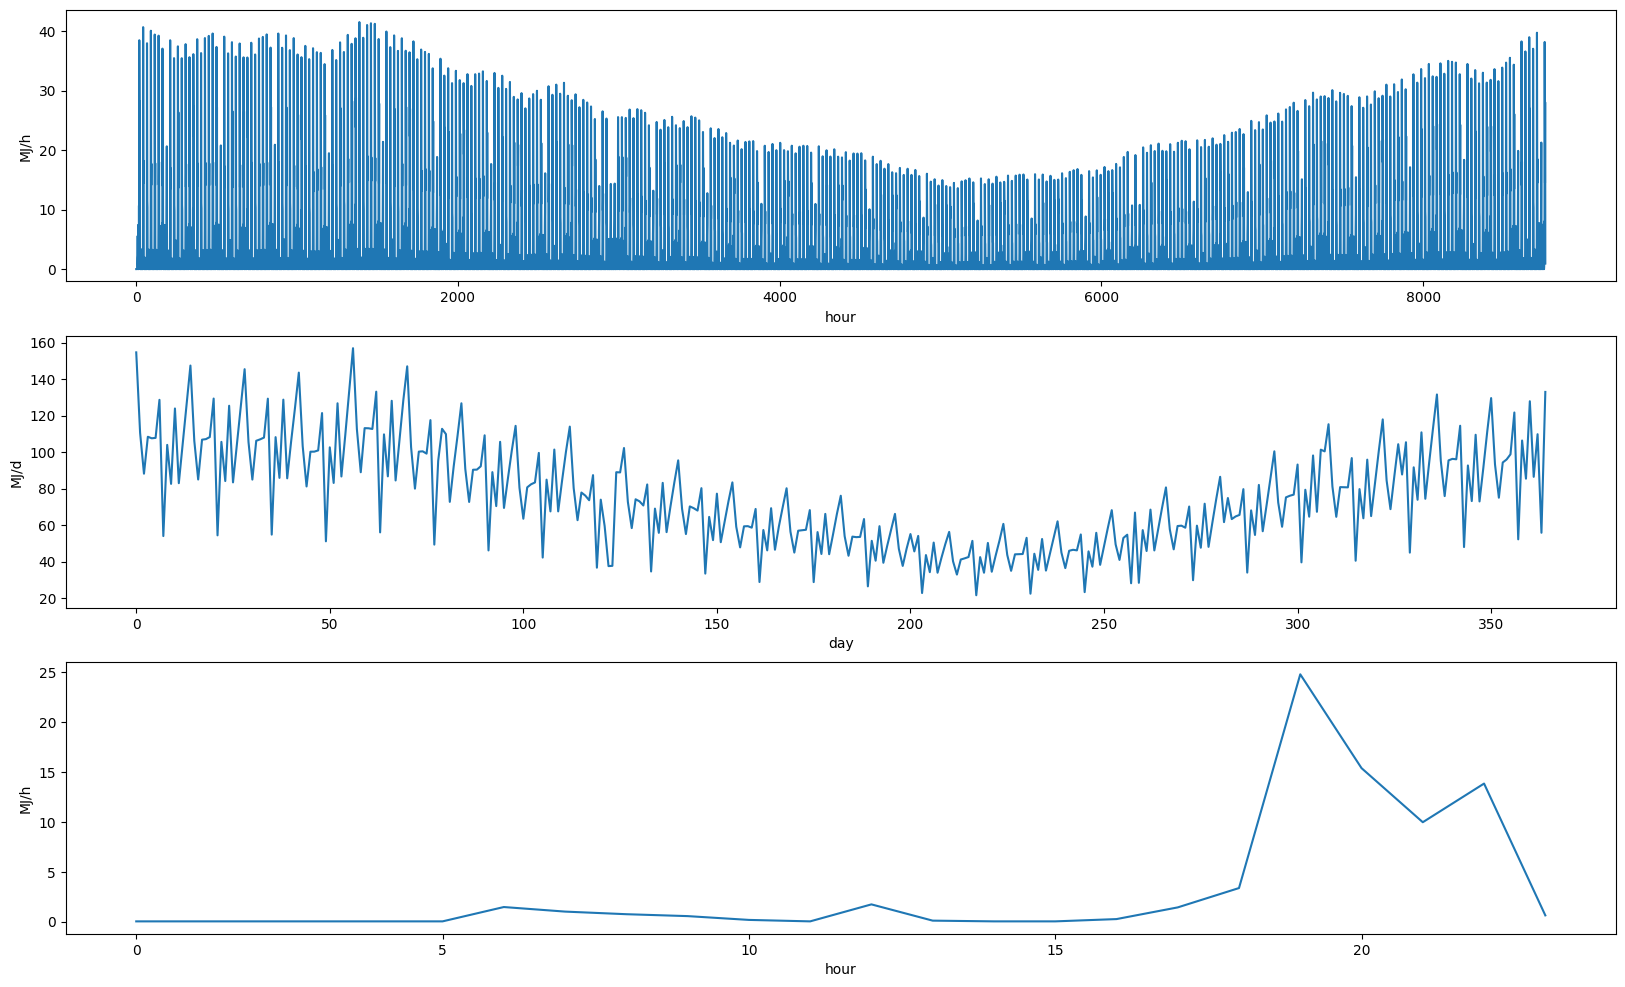

In [8]:
print('暖房')
get_each_graph(E_H_d_t_2)
print('給湯')
get_each_graph(E_W_d_t_2)

### 計算条件3

- 給湯利用あり
- 循環ポンプの自立運転用太陽光発電装置を採用する
- 給湯部のタンク容量100L

In [9]:
base, HW, SHC = get_default_air_based_solar_system()
SHC['hotwater_use'] = True
SHC['pump_sso'] = True
SHC['W_tnk_ass'] = 100
E_H_d_t_3, E_W_d_t_3 = calc_results(base, HW, SHC)

空気集熱式太陽熱利用設備の補機の消費電力量のうちの暖房設備への付加分 E_E_aux_ass = 3.9120000000000004 [kWh/年]
L_ba = 1339.0568333333335
W_k = 35806.0
W_s = 58690.0
W_w = 9454.0
W_b1 = 0.0
W_b2 = 60300.0
W_ba1 = 0.0
W_dash_k = 35806.0
W_dash_s = 58690.0
W_dash_w = 9454.0
W_dash_b1 = 0.0
W_dash_b2 = 60300.0
W_dash_ba1 = 0.0
L_dash_k = 3622.896051970286
L_dash_s = 5940.34804910638
L_dash_w = 957.2672611235673
L_dash_b1 = 0.0
L_dash_b2 = 6097.813467345601
L_dash_ba1 = 0.0
L_dash_ba2 = 1673.8210416666666
L_dashdash_k = 3595.508920871034
L_dashdash_s = 5892.888719748555
L_dashdash_w = 949.8600742210136
L_dashdash_b1 = 0.0
L_dashdash_b2 = 6049.040521006056
L_dashdash_ba1 = 0.0
L_dashdash_ba2 = 1673.8210416666666
E_E_hs_aux1 = 37.22433263888889
E_E_hs_aux2 = 6.513888888888888
E_E_hs_aux3 = 13.686551818865741
E_H_d_t = 13969.494179380305MJ/a
E_W_d_t = 27645.42664475845MJ/a


暖房


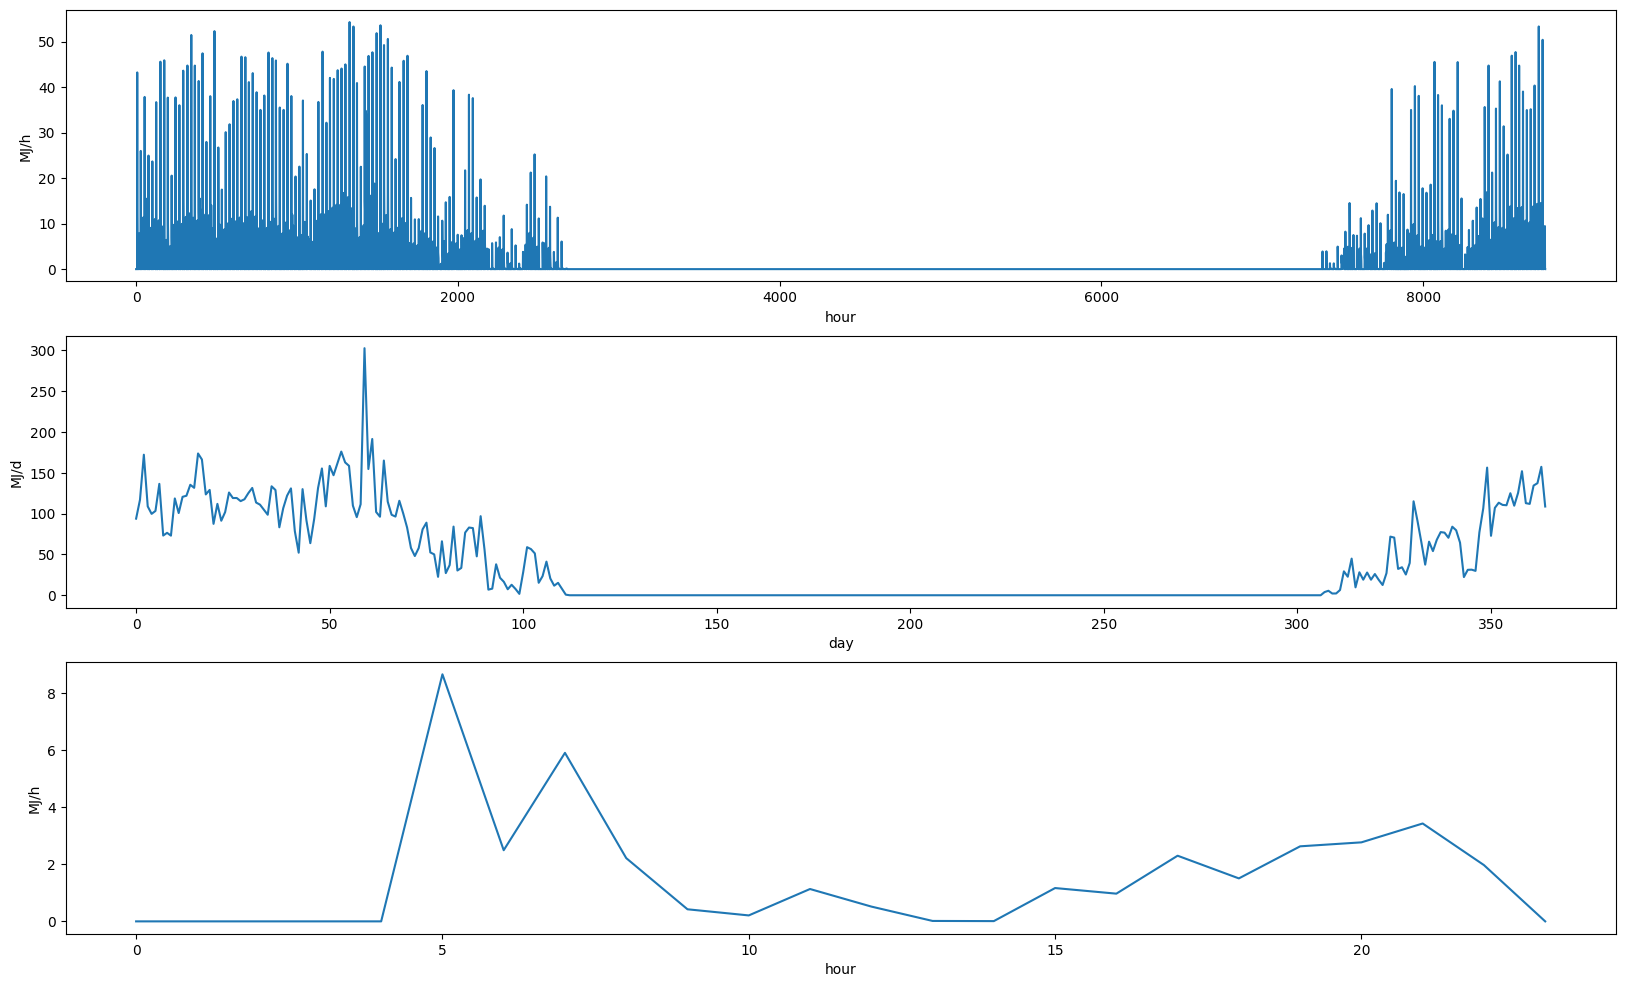

給湯


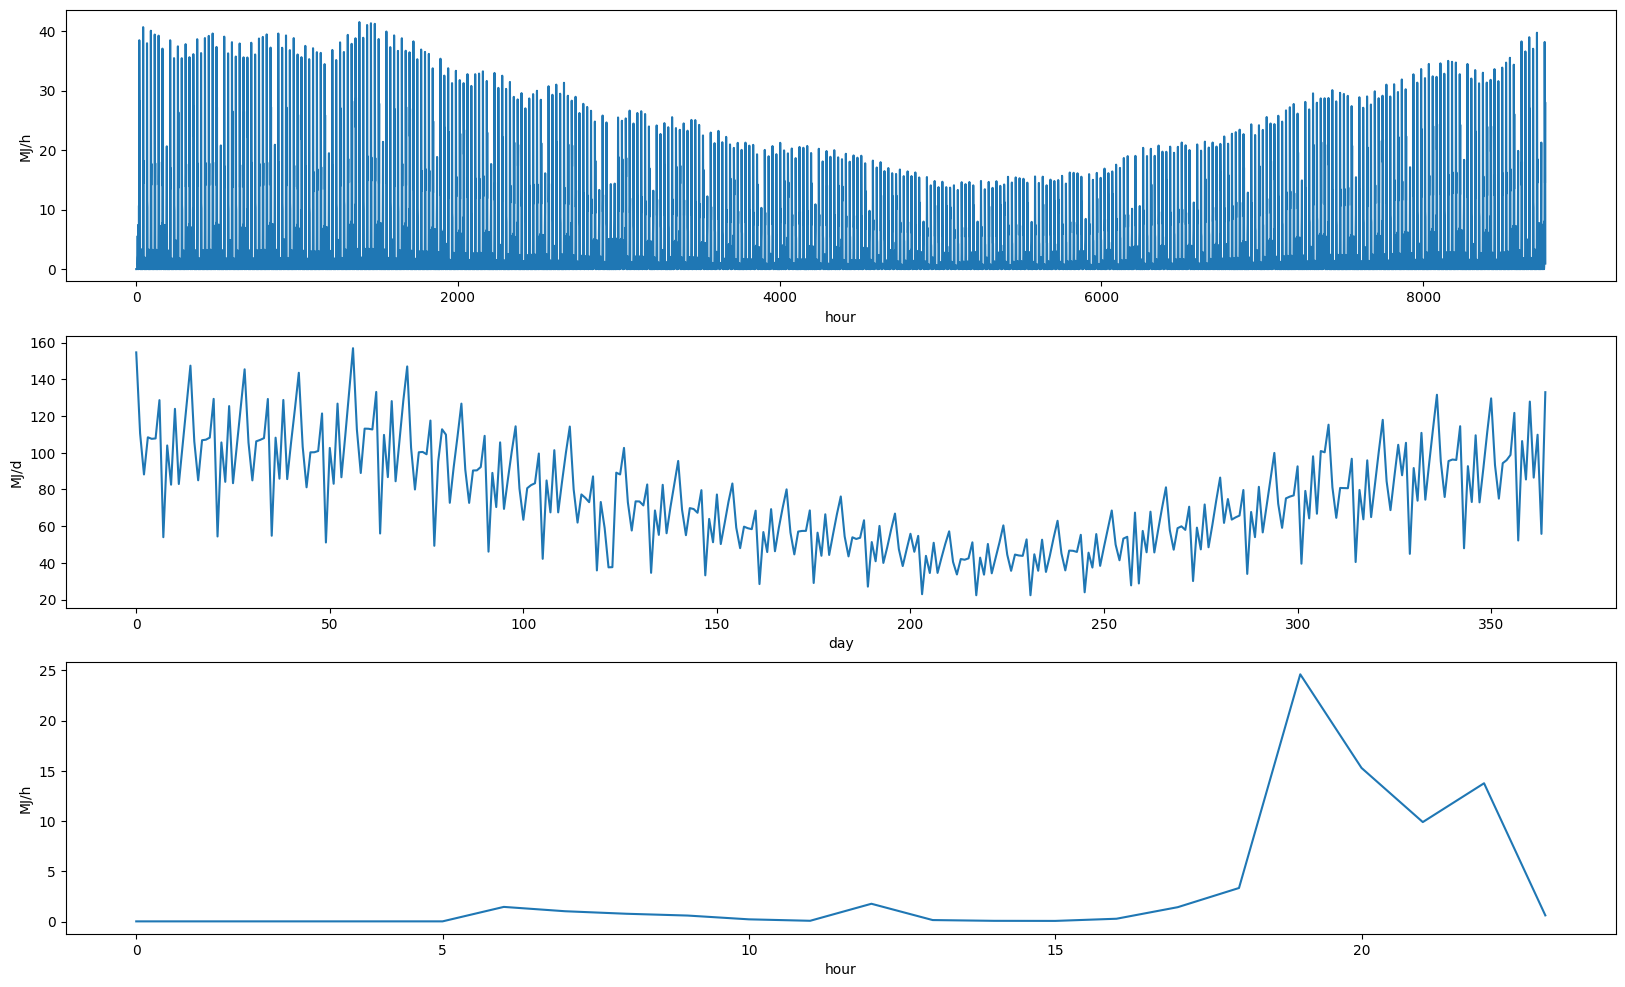

In [10]:
print('暖房')
get_each_graph(E_H_d_t_3)
print('給湯')
get_each_graph(E_W_d_t_3)

### 計算条件4

- 床下に床下集熱後の空気を供給
- 集熱後の空気を供給する床下の面積の割合100%
- 床下空間を断熱区画内

In [11]:
base, HW, SHC = get_default_air_based_solar_system()
SHC['supply_target'] = '床下'
SHC['r_A_ufvnt_ass'] = 1
SHC['ufv_insulation'] = True
E_H_d_t_4, E_W_d_t_4 = calc_results(base, HW, SHC)

空気集熱式太陽熱利用設備の補機の消費電力量のうちの暖房設備への付加分 E_E_aux_ass = 3.9120000000000004 [kWh/年]
E_E_hs_aux1 = 37.22433263888889
E_E_hs_aux2 = 6.513888888888888
E_E_hs_aux3 = 13.686551818865741
E_H_d_t = 13973.152900014109MJ/a
E_W_d_t = 27637.31547105188MJ/a


暖房


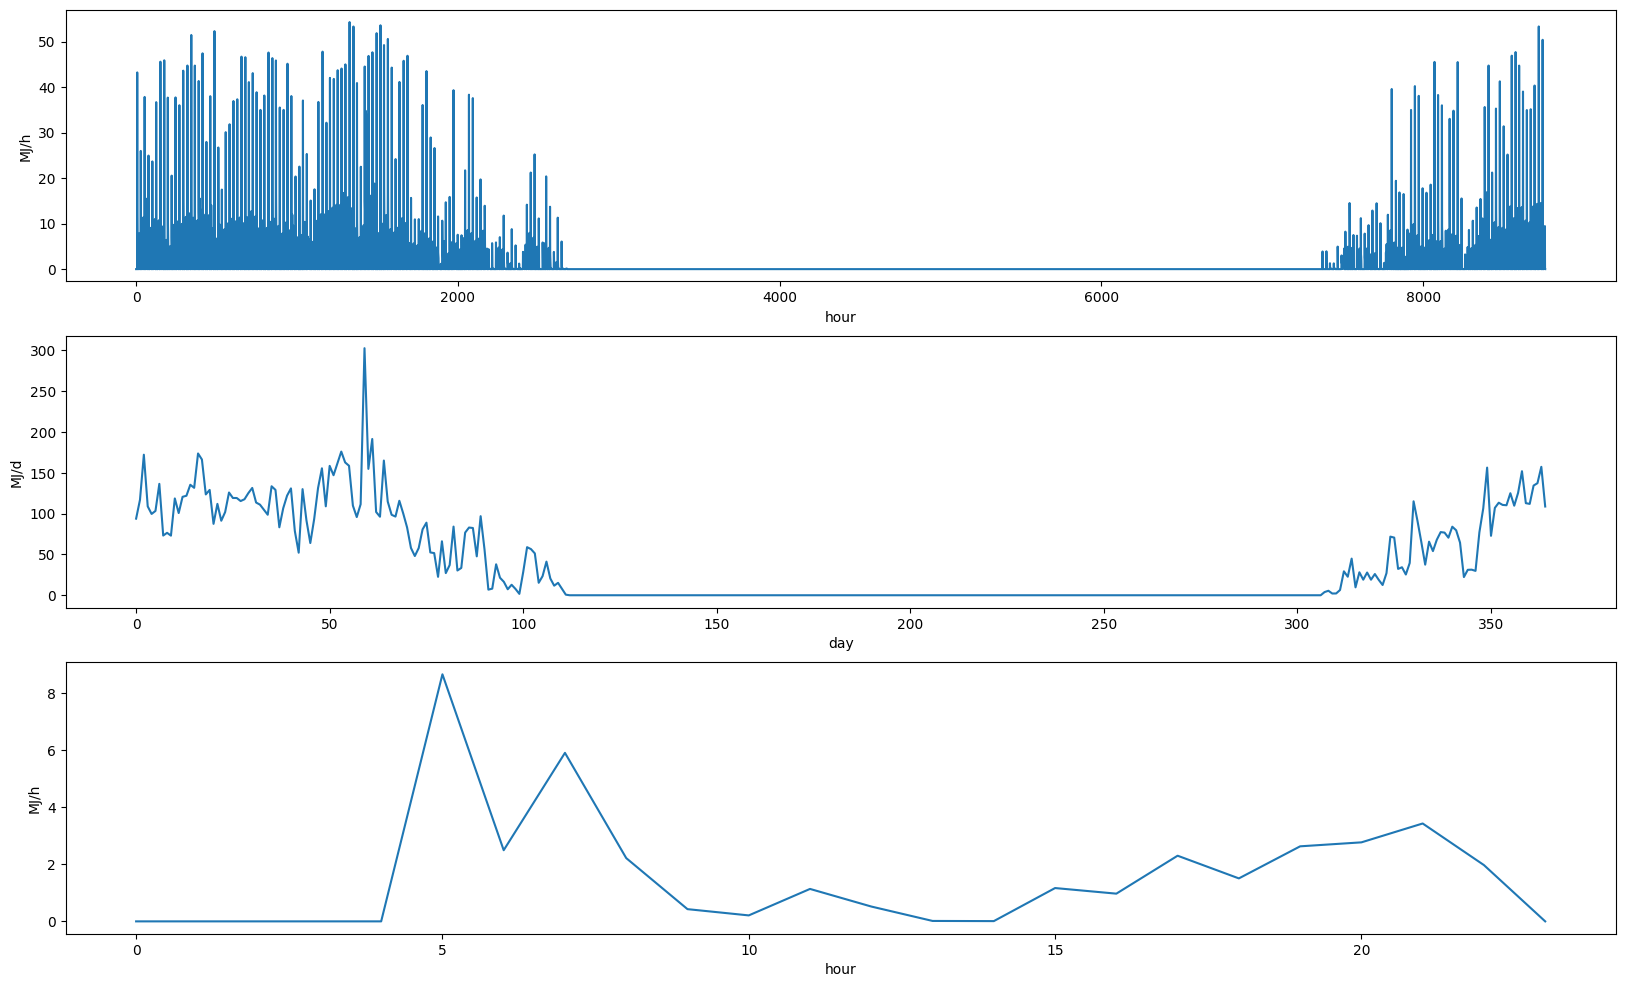

給湯


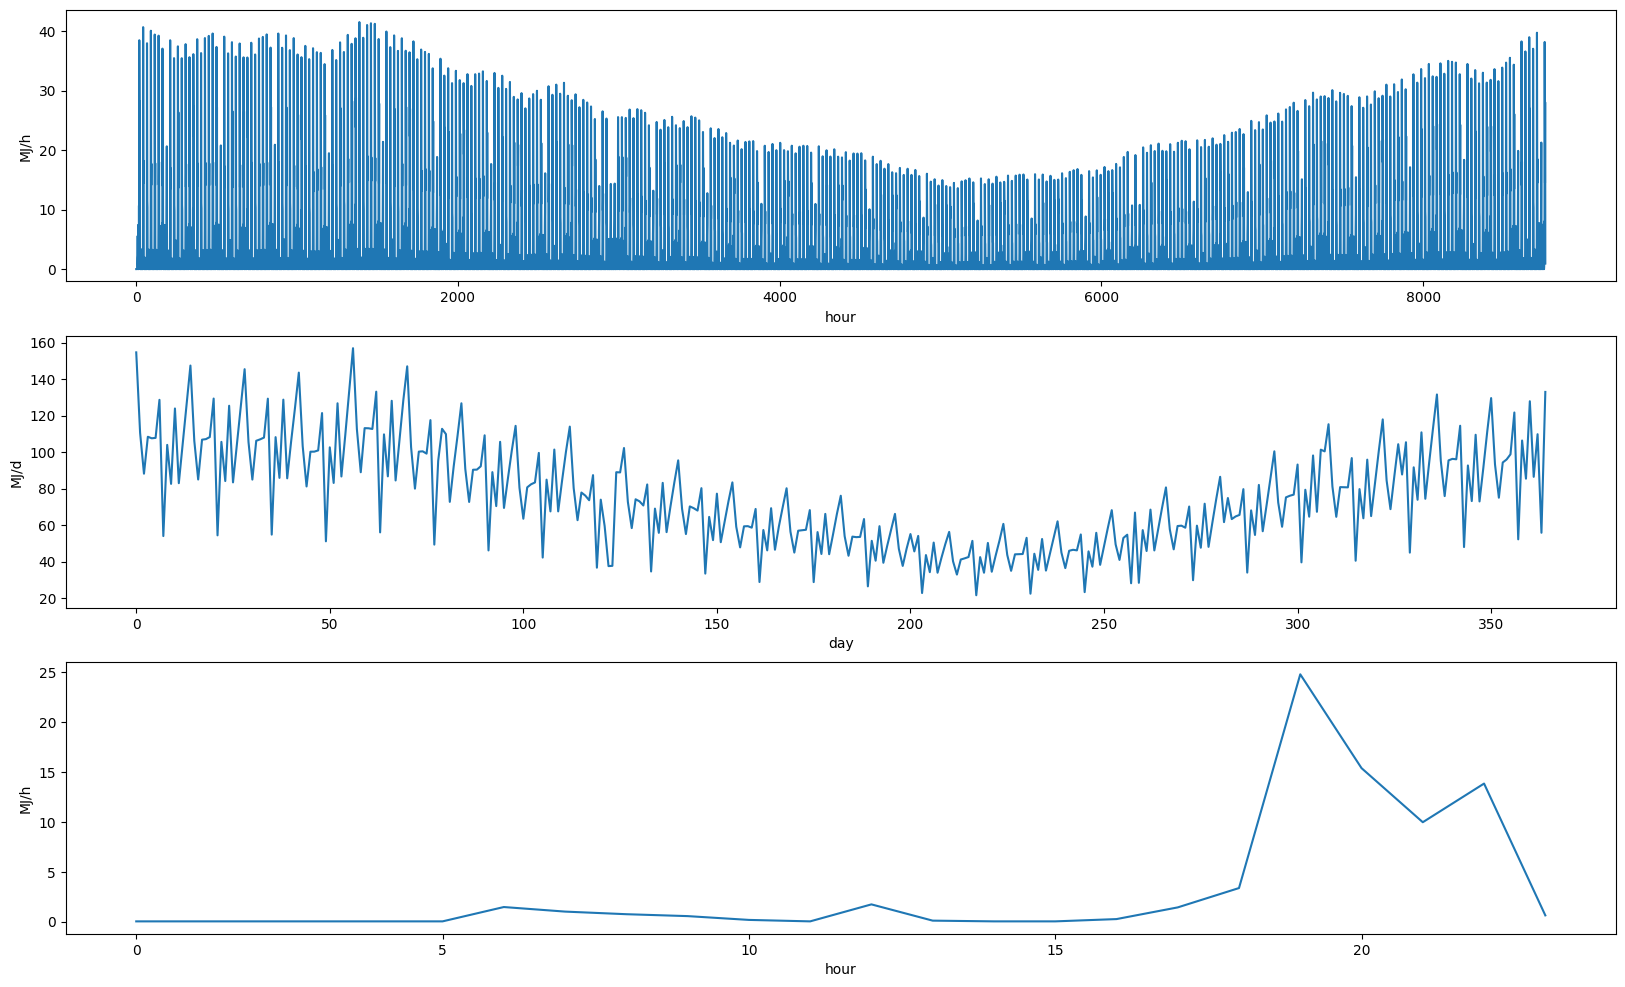

In [12]:
print('暖房')
get_each_graph(E_H_d_t_4)
print('給湯')
get_each_graph(E_W_d_t_4)

### 計算条件5

- 集熱器群を2つに変更

In [13]:
base, HW, SHC = get_default_air_based_solar_system()
SHC['A_col'] = (3, 5)
SHC['P_beta'] = (30, 50)
SHC['d0'] = (0.1, 0.2)
SHC['d1'] = (2.0, 2.2)
SHC['m_fan_test'] = (0.0107, 0.014)
E_H_d_t_5, E_W_d_t_5 = calc_results(base, HW, SHC)

空気集熱式太陽熱利用設備の補機の消費電力量のうちの暖房設備への付加分 E_E_aux_ass = 9.18 [kWh/年]
L_ba = 1339.0568333333335
W_k = 35806.0
W_s = 58690.0
W_w = 9454.0
W_b1 = 0.0
W_b2 = 60300.0
W_ba1 = 0.0
W_dash_k = 35806.0
W_dash_s = 58690.0
W_dash_w = 9454.0
W_dash_b1 = 0.0
W_dash_b2 = 60300.0
W_dash_ba1 = 0.0
L_dash_k = 3622.896051970286
L_dash_s = 5940.34804910638
L_dash_w = 957.2672611235673
L_dash_b1 = 0.0
L_dash_b2 = 6097.813467345601
L_dash_ba1 = 0.0
L_dash_ba2 = 1673.8210416666666
L_dashdash_k = 3622.896051970286
L_dashdash_s = 5940.34804910638
L_dashdash_w = 957.2672611235673
L_dashdash_b1 = 0.0
L_dashdash_b2 = 6097.813467345601
L_dashdash_ba1 = 0.0
L_dashdash_ba2 = 1673.8210416666666
E_E_hs_aux1 = 37.22433263888889
E_E_hs_aux2 = 6.513888888888888
E_E_hs_aux3 = 13.686551818865741
E_H_d_t = 13951.726994186825MJ/a
E_W_d_t = 27637.31547105188MJ/a


暖房


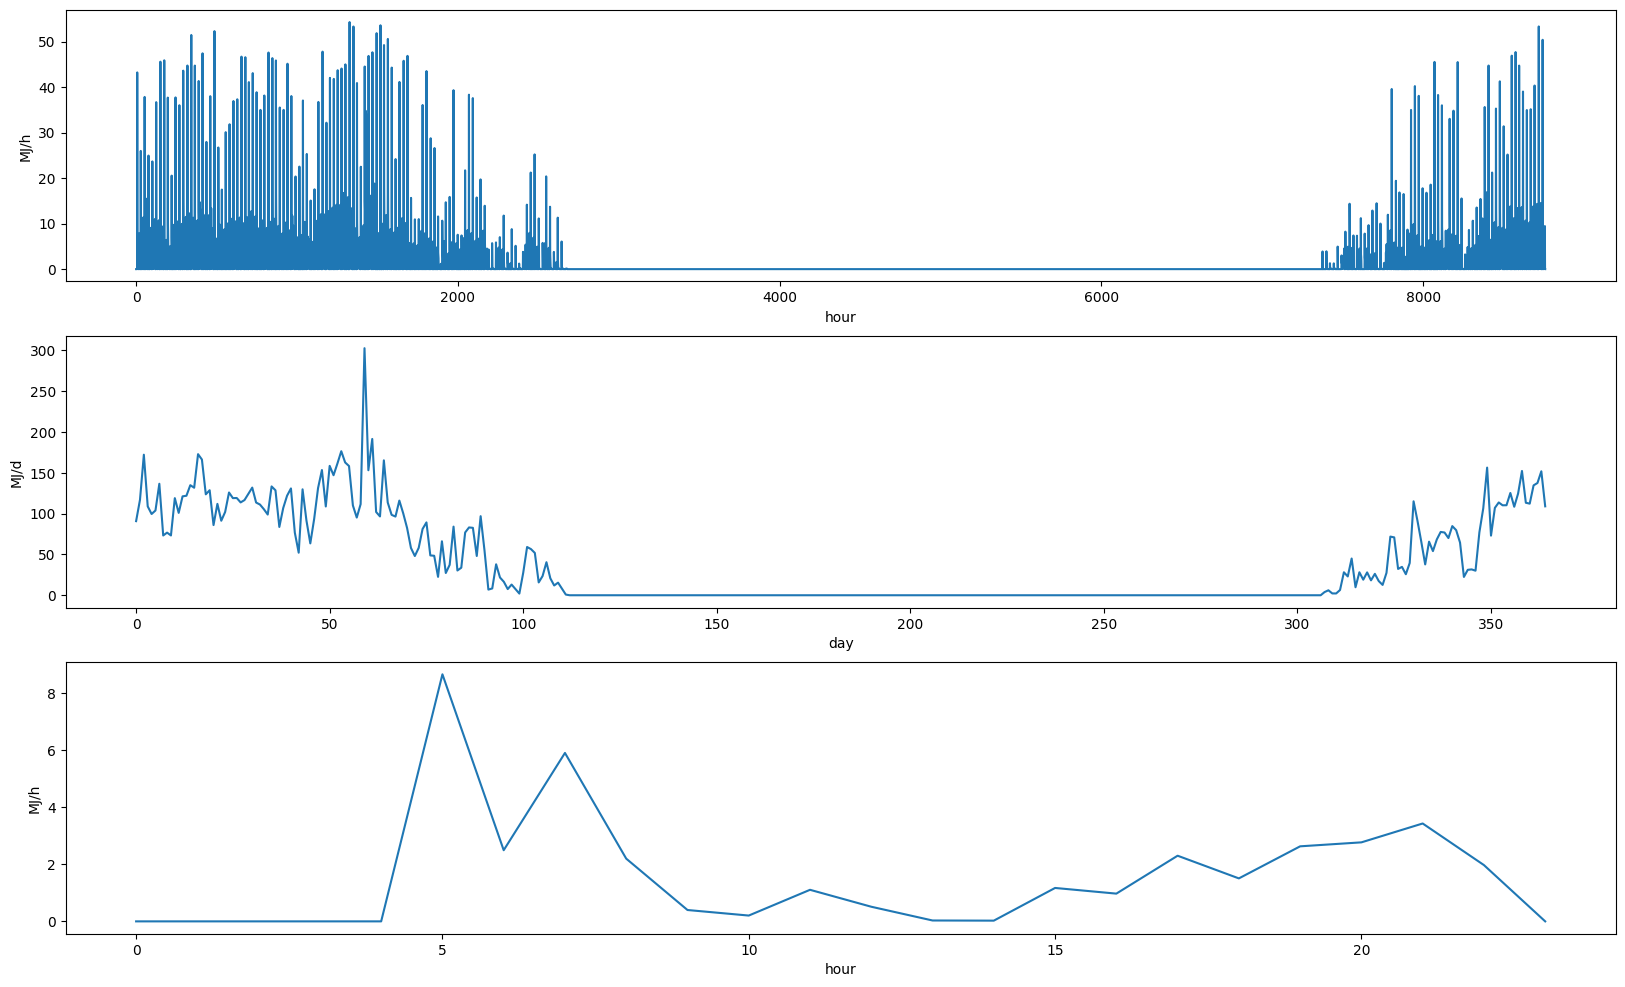

給湯


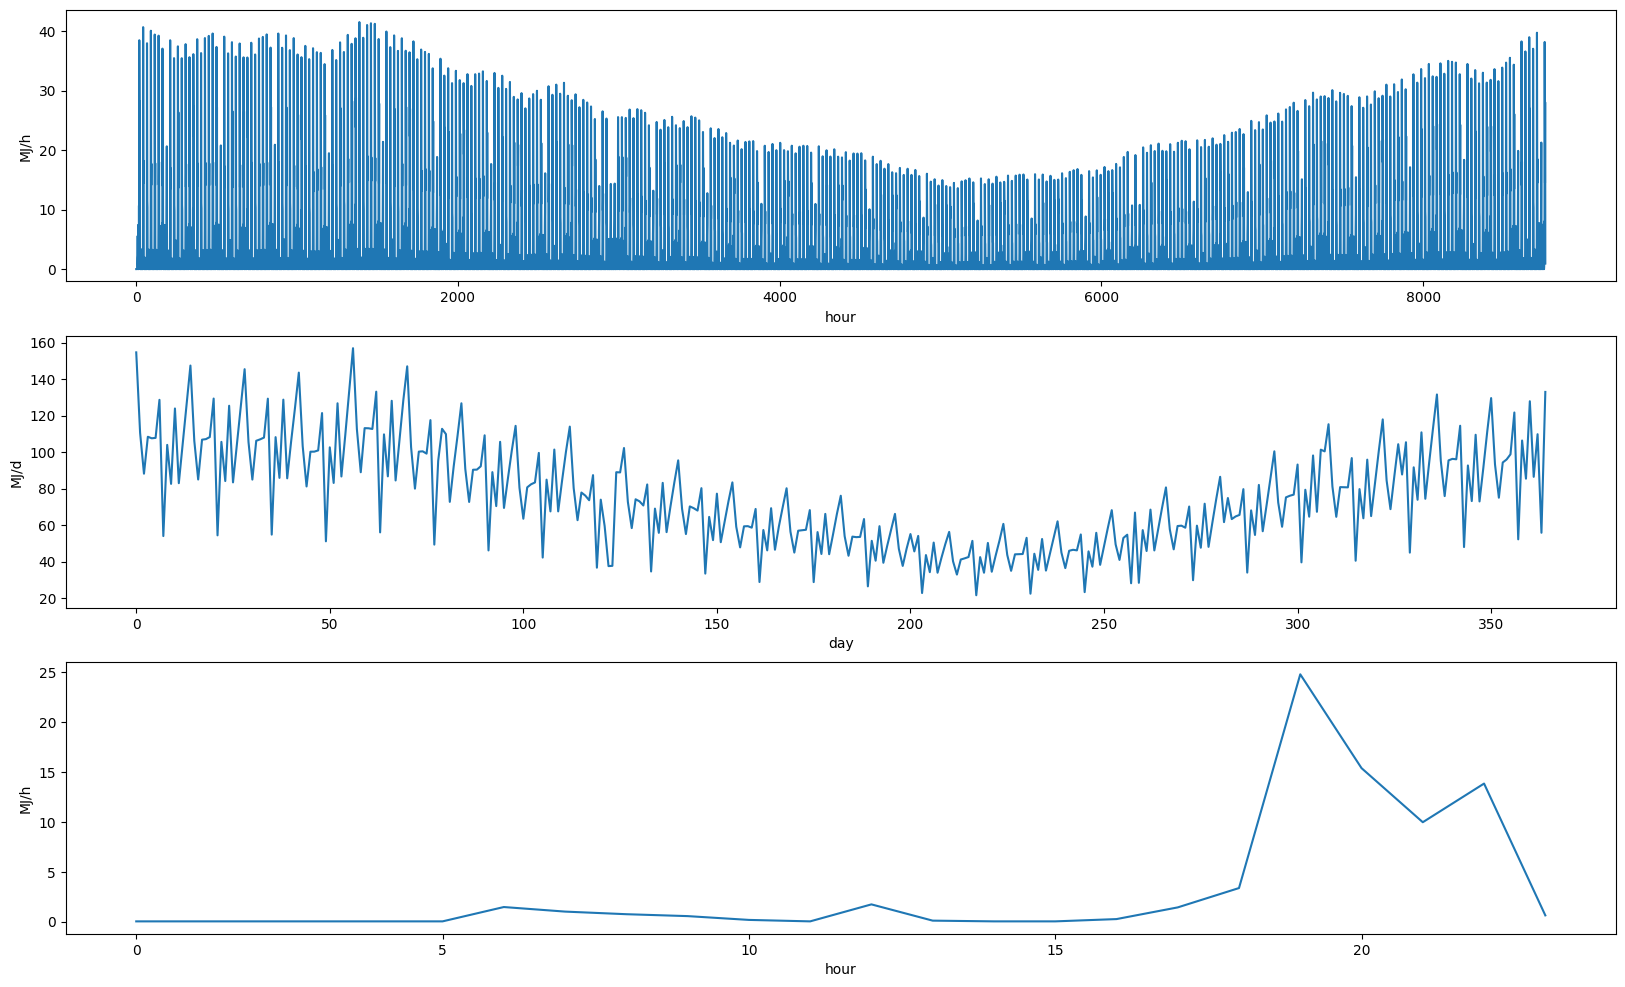

In [14]:
print('暖房')
get_each_graph(E_H_d_t_5)
print('給湯')
get_each_graph(E_W_d_t_5)

## 比較

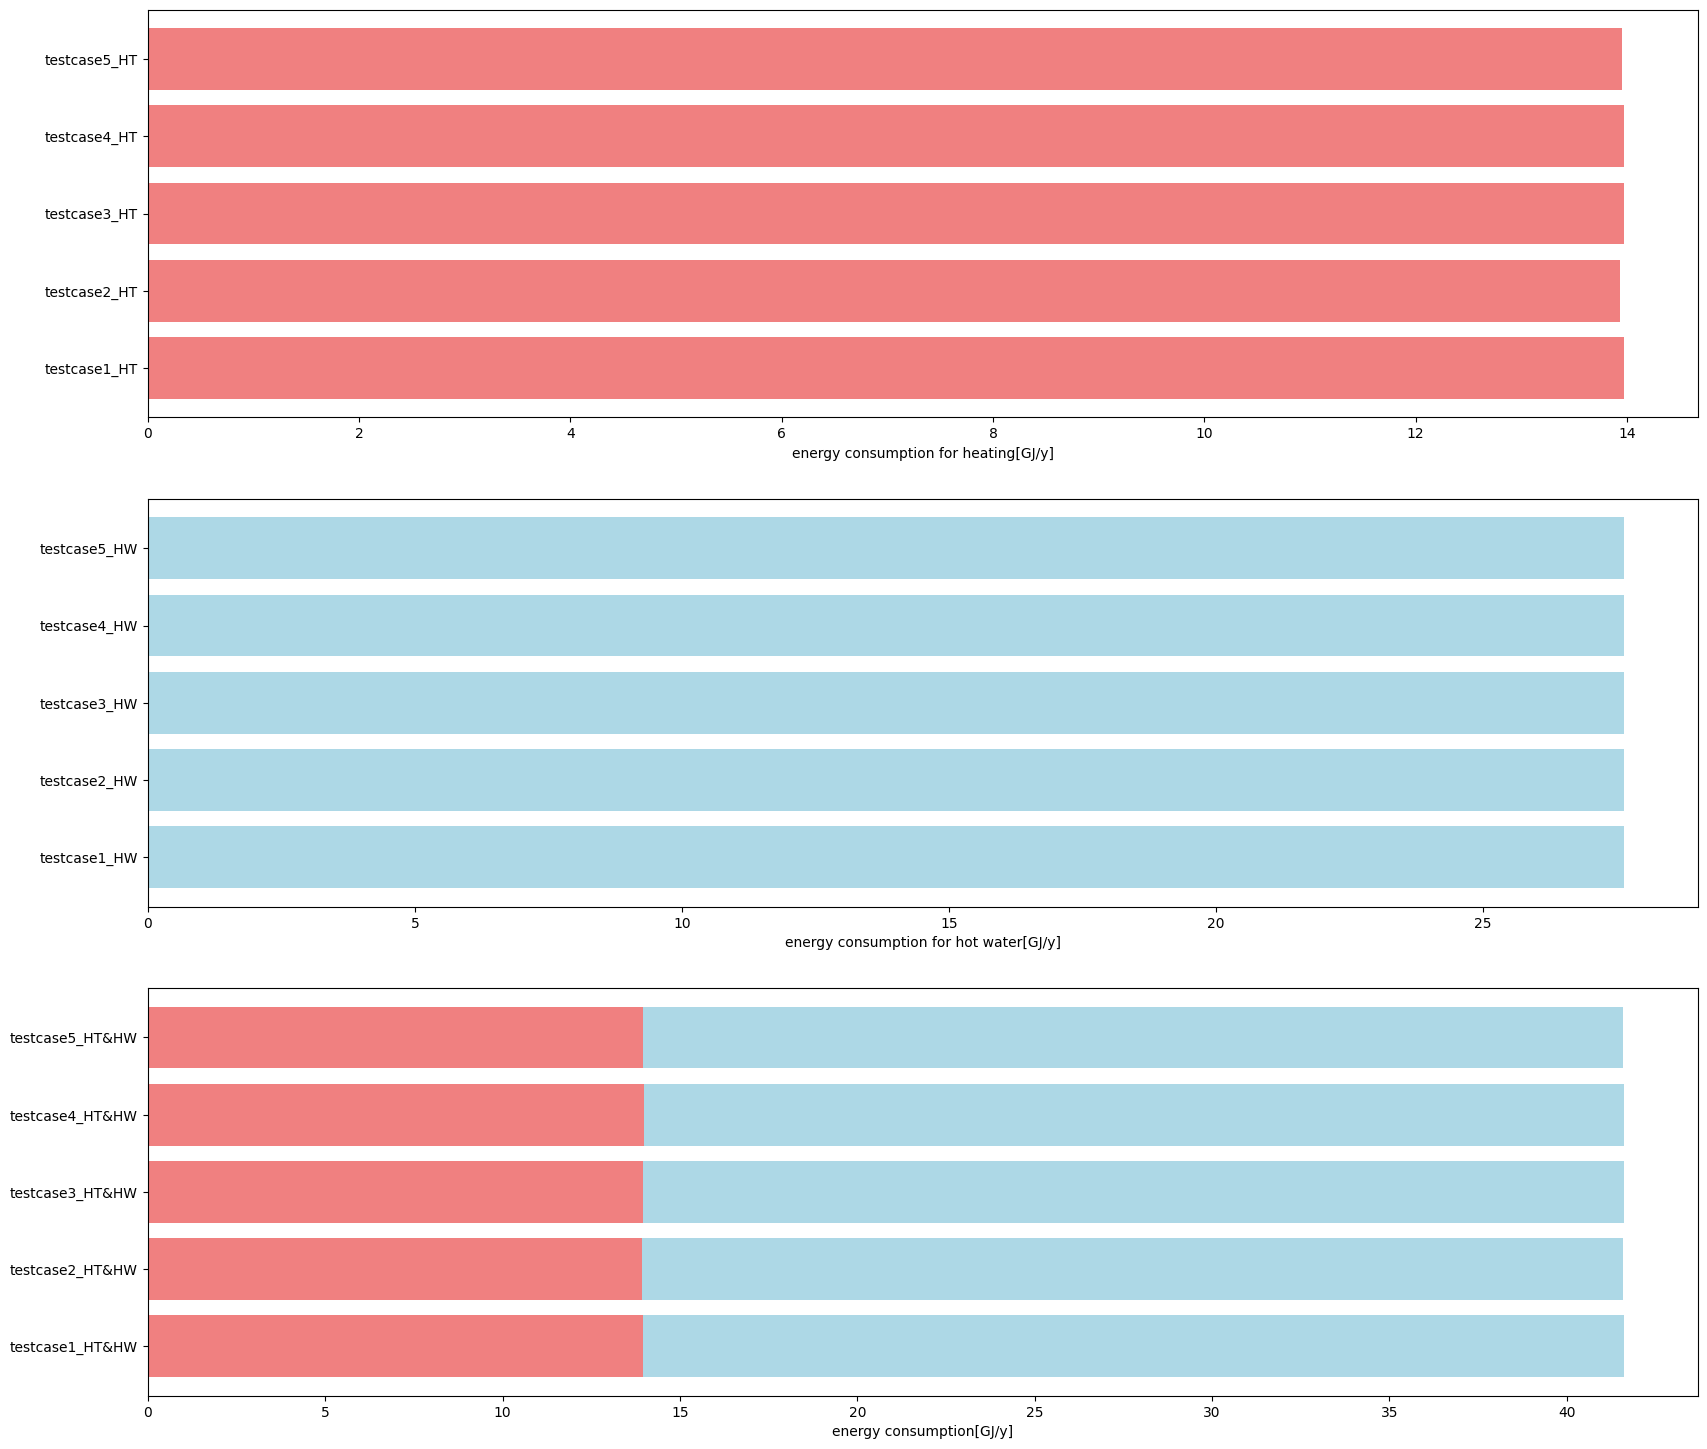

In [15]:
import matplotlib.pyplot as plt

dat_HT = {"testcase1_HT": np.sum(E_H_d_t_1)/1000, "testcase2_HT": np.sum(E_H_d_t_2)/1000, "testcase3_HT": np.sum(E_H_d_t_3)/1000, 
         "testcase4_HT": np.sum(E_H_d_t_4)/1000, "testcase5_HT": np.sum(E_H_d_t_5)/1000}

dat_HW = {"testcase1_HW": np.sum(E_W_d_t_5)/1000, "testcase2_HW": np.sum(E_W_d_t_2)/1000, "testcase3_HW": np.sum(E_W_d_t_3)/1000, 
         "testcase4_HW": np.sum(E_W_d_t_4)/1000, "testcase5_HW": np.sum(E_W_d_t_5)/1000}


x_HT = list(dat_HT.keys())
y_HT = list(dat_HT.values())

x_HW = list(dat_HW.keys())
y_HW = list(dat_HW.values())

x_HTHW = ["testcase1_HT&HW", "testcase2_HT&HW", "testcase3_HT&HW", "testcase4_HT&HW", "testcase5_HT&HW"]

fig = plt.figure(figsize=(20,18))

grh_H = fig.add_subplot(311)
grh_H.barh(x_HT,y_HT, color = "lightcoral")
grh_H.set_xlabel("energy consumption for heating[GJ/y]")

grh_C = fig.add_subplot(312)
grh_C.barh(x_HW,y_HW, color = "lightblue")
grh_C.set_xlabel("energy consumption for hot water[GJ/y]")

grh_HC = fig.add_subplot(313)
grh_HC.barh(x_HTHW, y_HT, color = "lightcoral")
grh_HC.barh(x_HTHW, y_HW, left=y_HT, color="lightblue")
grh_HC.set_xlabel("energy consumption[GJ/y]")

plt.show()